In [569]:
import pandas as pd
import seaborn as sns
#import matplotlib as plt
import matplotlib.pyplot as plt
import os
from scipy.stats import chi2_contingency
%matplotlib inline
import numpy as np
import seaborn as sns
import igraph as ig
from scipy.spatial.distance import cdist
import netplotbrain
from nilearn import datasets
from nilearn import plotting

import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler, SplineTransformer
from sklearn.linear_model import Ridge
from sklearn.metrics import median_absolute_error

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, LeaveOneOut, cross_val_score
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [277]:
DIR=os.path.join("/NAS","tupac","protocoles","PULSE")

In [278]:
#lecture des fichiers excels
df_part = pd.read_excel(os.path.join(DIR,'Liste_participants.xlsx'))
df_cort = pd.read_excel(os.path.join(DIR,'valeurs_corticales_glasser360.xlsx'))
df_sscor2 = pd.read_excel(os.path.join(DIR,'valeurs_sous_corticales_keuken7T.xlsx'))
df_sscor1 = pd.read_excel(os.path.join(DIR,'valeurs_sous_corticales_Volbrain.xlsx'))

In [279]:
df_roi = pd.read_csv(os.path.join(DIR,'Coord_ROI_atlas_inMNI.csv'))
df_roi = df_roi.drop('Name_inPulse', axis=1)
df_roi.set_index('Name_inAtlas', inplace=True)
df_roi

,X,Y,Z
Name_inAtlas,,,
R_amygdala,22.286025,-4.068067,-19.733526
L_amygdala,-21.742625,-5.337021,-19.808260
R_caudate,13.781250,10.302004,9.587786
L_caudate,-12.909930,9.549651,9.286178
R_hippocampus,26.481760,-21.424464,-13.697425
...,...,...,...
L_STSva,-52.357733,-9.350649,-16.895514
L_TE1m,-64.656484,-26.864331,-14.723270
L_PI,-44.851888,-4.322362,-13.133591


In [280]:
df_sscor1.filter(regex="Mediane")

,Mediane Amygdale droit,Mediane Amygdale gauche,Mediane Tête du noyau caudé droit,Mediane Tête du noyau caudé gauche,Mediane Hippocampe droit,Mediane Hippocampe gauche,Mediane Pallidum droit,Mediane Pallidum gauche,Mediane Putamen droit,Mediane Putamen gauche,Mediane Thalamus droit,Mediane Thalamus gauche,Mediane Insula antérieur droit,Mediane Insula antérieur gauche,Mediane Insula postérieur droit,Mediane Insula postérieur gauche
0,26.198459,25.593589,26.048285,25.771546,26.041669,24.388896,38.938128,37.995128,29.965459,28.159587,26.878847,27.481970,25.155101,24.413843,25.371142,23.247397
1,23.831634,23.575501,26.811122,26.708317,24.803066,24.214032,36.760619,36.113821,28.804919,29.074923,26.246781,26.354877,23.889264,24.127288,25.104708,24.660694
2,24.135123,24.615499,27.129291,27.983717,24.159110,24.429229,35.985913,35.512419,30.090314,29.433848,26.351680,26.367427,24.036504,23.294527,24.437717,23.050168
3,24.735790,26.049833,26.838183,28.201485,24.495157,25.501065,38.595161,36.052709,31.269775,31.002921,26.772382,27.211766,24.380496,24.461955,23.472464,24.416252
4,23.726024,23.124884,30.222176,27.671232,23.826502,26.063287,40.623184,38.940361,32.859152,32.682314,25.053248,25.779835,23.694959,24.438006,22.417778,22.727109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,22.496495,23.886183,29.074727,28.861689,24.454439,24.936971,34.052030,34.974462,32.219548,31.979106,25.092757,25.383706,23.194595,23.730367,23.662669,23.378711
177,22.167099,23.370389,27.031612,27.846520,23.750106,23.369864,30.339524,30.434881,29.302672,29.792240,25.754949,26.320754,22.828320,23.637046,25.030380,24.801180
178,27.047280,25.539510,26.865910,26.549033,26.154003,23.352849,43.566368,43.471663,30.110483,29.255517,28.168291,28.542197,25.040667,25.395977,23.315114,25.354172
179,23.695595,24.266116,26.662369,27.424377,22.922987,24.019608,40.170723,44.238158,30.861094,30.656075,28.632268,28.454037,24.871976,24.660539,22.322119,25.510945


In [281]:
#Mise à jour des index
df_sscor1.set_index('Participant', inplace=True)
df_sscor2.set_index('SUBJID', inplace=True)
df_cort.set_index('SUBJID', inplace=True)
df_part.set_index('participant_id', inplace=True)

In [282]:
#création de data #filter(regex="R2")
data=df_sscor1.filter(regex="Mediane").join(df_sscor2.filter(regex="Mediane")).join(df_cort.filter(regex="Mediane"))
data.columns=df_roi.index
print(data.shape)
nozero_cols = data.columns[data.all()]
data=data[nozero_cols]
df_roi=df_roi.loc[nozero_cols.values]
print(data.shape)

(181, 384)
(181, 333)


In [288]:
cols_index = list(range(24))
cols_names = ['R_4', 'L_4']
cols_to_keep = cols_index + [data.columns.get_loc(name) for name in cols_names]
print(cols_to_keep)
print(data.columns[cols_to_keep])
data = data.iloc[:, cols_to_keep]
df_roi = df_roi.iloc[cols_to_keep,:]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 27, 164]
Index(['R_amygdala', 'L_amygdala', 'R_caudate', ' L_caudate', 'R_hippocampus',
       'L_hippocampus', 'R_pallidum', 'L_pallidum', 'R_putamen', 'L_putamen',
       'R_thalamus', 'L_thalamus', 'R_anterior insula', 'L_anterior insula',
       'R_posterior insula', 'L_posterior insula', 'L_RN', 'L_SN', 'L_GPe',
       'L_GPi', 'R_RN', 'R_SN', 'R_GPe', 'R_GPi', 'R_4', 'L_4'],
      dtype='object', name='Name_inAtlas')


In [283]:
df=df_part[['Declin','AGE','SEXE','SITE_APP','Score_de_declin']].dropna().join(data)
df=df.dropna()

In [426]:
def combine_gp(row):
    return row['SITE_APP'] + '_' + row['Declin']

def combine_gp4Pred(row):
    if row['Score_de_declin_predit']>0.6 :
        return row['SITE_APP'] + '_Fast'
    else :
        return row['SITE_APP'] + '_Slow'

df['Site_declin'] = df.apply(combine_gp, axis=1)

In [285]:
df = df.rename(columns=lambda x: x.replace("Mediane ", ""))

### Rige_regression 

Modèle de prédiction du score de déclin : <br>
* Regression linéaire avec regularisation L2 <br>
* Validation croisée pour les hyperparamètres <br>
* Et évaluation du modèle par Leave One Out <br>


In [494]:
#AVEC la cross-validation pour le parametres alpha
df=df_part[['Declin','AGE','SEXE','SITE_APP','Score_de_declin']].dropna().join(data)
df=df.dropna()
df['Site_declin'] = df.apply(combine_gp, axis=1)
df = df.rename(columns=lambda x: x.replace("Mediane ", ""))

# Séparer la colonne à prédire "declin" du DataFrame
X = df.drop(columns=['Declin','Score_de_declin','Site_declin'])
y = df['Score_de_declin']

# Encoder les variables catégorielles en utilisant OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore')
X_encoded = encoder.fit_transform(X.select_dtypes(include=['object', 'category']))

# Rescaler les variables quantitatives en utilisant SplineTransformer
transformer = SplineTransformer(degree=3)
X_rescaled = transformer.fit_transform(X.select_dtypes(include=np.number))

# Concaténer les variables encodées et les variables rescalées en un seul DataFrame
X = np.concatenate((X_encoded.toarray(),X_rescaled),axis=1)

# 2. Création du pipeline de traitement des données

# Créer un pipeline en utilisant Pipeline de scikit-learn pour combiner les étapes de prétraitement des données et la régression Ridge
pipeline = Pipeline([
    ('ridge', Ridge(alpha=0.1))
])

# 3. Optimisation de l'hyperparamètre alpha en utilisant une validation croisée

# Créer un objet GridSearchCV de scikit-learn pour effectuer une recherche de grille sur l'hyperparamètre alpha en utilisant une validation croisée
#grid_search = GridSearchCV(pipeline, param_grid={'ridge__alpha': [0.1, 1, 10, 100]},  scoring=median_absolute_error, refit=True)

# Exécuter la recherche de grille en utilisant l'objet GridSearchCV sur le pipeline de traitement des données et les données d'entrée et de sortie
#grid_search.fit(X, y)

# Afficher la meilleure valeur de l'hyperparamètre alpha
#print('Meilleure valeur de l\'hyperparamètre alpha :', grid_search.best_params_['ridge__alpha'])

# 4. Évaluation du modèle en Leave One Out

# Créer un objet LeaveOneOut de scikit-learn pour effectuer une évaluation en Leave One Out
loo = LeaveOneOut()

# Exécuter l'évaluation en Leave One Out en utilisant l'objet LeaveOneOut sur le pipeline de traitement des données et les données d'entrée et de sortie
scores = []
y_true=[]
y_pred=[]
for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    pipeline.fit(X_train, y_train)
    score = median_absolute_error(y_test, pipeline.predict(X_test))
    y_true.append(y_test)
    y_pred.append(pipeline.predict(X_test)[0])
    scores.append(score)

# Afficher la moyenne et l'écart-type des scores
print('Moyenne des scores :', np.mean(scores))

#AJOUT
df['Score_de_declin_predit']=np.array(y_pred)[:]

print("ICI")
print("ICI")
print("ICI")
print("ICI")

#DEUX
# Séparer la colonne à prédire "declin" du DataFrame
X = df.drop(columns=['Declin','Score_de_declin','Site_declin'])
y = df['Score_de_declin']

# Encoder les variables catégorielles en utilisant OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore')
X_encoded = encoder.fit_transform(X.select_dtypes(include=['object', 'category']))

# Rescaler les variables quantitatives en utilisant SplineTransformer
transformer = SplineTransformer(degree=3)
X_rescaled = transformer.fit_transform(X.select_dtypes(include=np.number))

# Concaténer les variables encodées et les variables rescalées en un seul DataFrame
X = np.concatenate((X_encoded.toarray(),X_rescaled),axis=1)

# 2. Création du pipeline de traitement des données

# Créer un pipeline en utilisant Pipeline de scikit-learn pour combiner les étapes de prétraitement des données et la régression Ridge
pipeline = Pipeline([
    ('ridge', Ridge(alpha=0.1))
])

# 3. Optimisation de l'hyperparamètre alpha en utilisant une validation croisée

# Créer un objet GridSearchCV de scikit-learn pour effectuer une recherche de grille sur l'hyperparamètre alpha en utilisant une validation croisée
#grid_search = GridSearchCV(pipeline, param_grid={'ridge__alpha': [0.1, 1, 10, 100]},  scoring=median_absolute_error, refit=True)

# Exécuter la recherche de grille en utilisant l'objet GridSearchCV sur le pipeline de traitement des données et les données d'entrée et de sortie
#grid_search.fit(X, y)

# Afficher la meilleure valeur de l'hyperparamètre alpha
print('Meilleure valeur de l\'hyperparamètre alpha :', grid_search.best_params_['ridge__alpha'])

# 4. Évaluation du modèle en Leave One Out

# Créer un objet LeaveOneOut de scikit-learn pour effectuer une évaluation en Leave One Out
loo = LeaveOneOut()

# Exécuter l'évaluation en Leave One Out en utilisant l'objet LeaveOneOut sur le pipeline de traitement des données et les données d'entrée et de sortie
scores = []
y_true=[]
y_pred=[]
for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    pipeline.fit(X_train, y_train)
    score = median_absolute_error(y_test, pipeline.predict(X_test))
    y_true.append(y_test)
    y_pred.append(pipeline.predict(X_test)[0])
    scores.append(score)

# Afficher la moyenne et l'écart-type des scores
print('Moyenne des scores :', np.mean(scores))


Moyenne des scores : 0.7821851753110183
ICI
ICI
ICI
ICI


KeyError: 'ridge__alpha'

Moyenne MAE : 0.2710972177367095
Coefficient de détermination R² : 0.5790583644833955
Moyenne MAE : 0.20632641013315434
Coefficient de détermination R² : 0.736598921437027


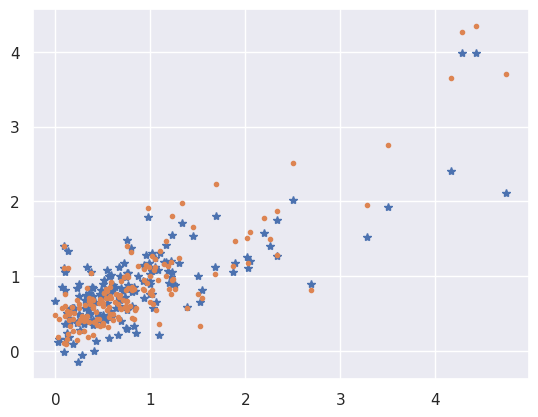

In [427]:
#Evaluation du modèle sur la base d'apprentissage /entrainement
df=df_part[['Declin','AGE','SEXE','SITE_APP','Score_de_declin']].dropna().join(data)
df=df.dropna()
df['Site_declin'] = df.apply(combine_gp, axis=1)
df = df.rename(columns=lambda x: x.replace("Mediane ", ""))
X = df.drop(columns=['Declin','Score_de_declin','Site_declin'])
y = df['Score_de_declin']

# Encoder les variables catégorielles en utilisant OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore')
X_encoded = encoder.fit_transform(X.select_dtypes(include=['object', 'category']))

X = df.drop(columns=['Declin','Score_de_declin','Site_declin'])
TMP_X=X.select_dtypes(include=np.number)
TMP=np.clip(TMP_X,np.quantile(TMP_X,0),np.quantile(TMP_X,0.99))
# Créer un objet MinMaxScaler()
scaler = MinMaxScaler()
# Rescaler les variables quantitatives en utilisant SplineTransformer
transformer = SplineTransformer(degree=3)

# Mettre à l'échelle chaque colonne du tableau entre 0 et 1
X_scaled = scaler.fit_transform(TMP)
X_rescaled = transformer.fit_transform(TMP_X)
X = np.concatenate((X_encoded.toarray(),X_rescaled),axis=1)

ridge1 = Ridge(alpha=0.1)
ridge1.fit(X, y)
y_pred=ridge1.predict(X)
scores = median_absolute_error(y, y_pred)

plt.figure()
plt.plot(y_true, y_pred,"*")
print('Moyenne MAE :', np.mean(scores))
r2 = r2_score(y_true, y_pred)
print('Coefficient de détermination R² :', r2)

df['Score_de_declin_predit']=np.array(y_pred)[:]

X = df.drop(columns=['Declin','Score_de_declin','Site_declin'])
y = df['Score_de_declin']

# Encoder les variables catégorielles en utilisant OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore')
X_encoded = encoder.fit_transform(X.select_dtypes(include=['object', 'category']))

X = df.drop(columns=['Declin','Score_de_declin','Site_declin'])
TMP_X=X.select_dtypes(include=np.number)
TMP=np.clip(TMP_X,np.quantile(TMP_X,0),np.quantile(TMP_X,0.99))
# Créer un objet MinMaxScaler()
scaler = MinMaxScaler()
# Rescaler les variables quantitatives en utilisant SplineTransformer
transformer = SplineTransformer(degree=3)

# Mettre à l'échelle chaque colonne du tableau entre 0 et 1
X_scaled = scaler.fit_transform(TMP)
X_rescaled = transformer.fit_transform(TMP_X)
X = np.concatenate((X_encoded.toarray(),X_rescaled),axis=1)

ridge1 = Ridge(alpha=0.1)
ridge1.fit(X, y)
y_pred=ridge1.predict(X)
scores = median_absolute_error(y, y_pred)

plt.plot(y_true, y_pred,".")
print('Moyenne MAE :', np.mean(scores))
r2 = r2_score(y_true, y_pred)
print('Coefficient de détermination R² :', r2)

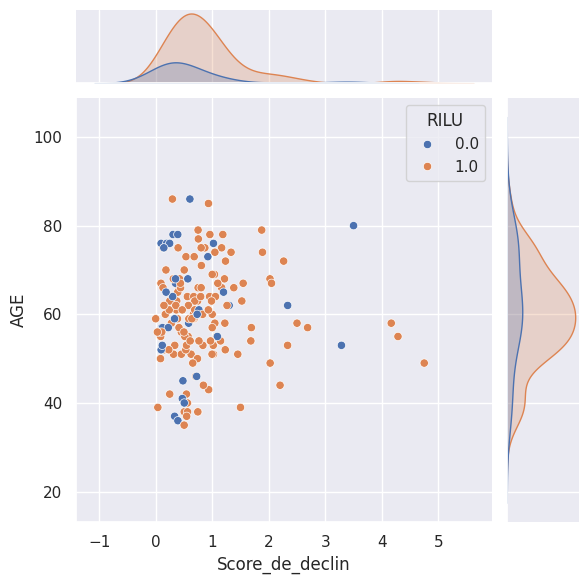

In [516]:
sns.jointplot(x='Score_de_declin',y='AGE', data=df, color='red',hue="RILU")

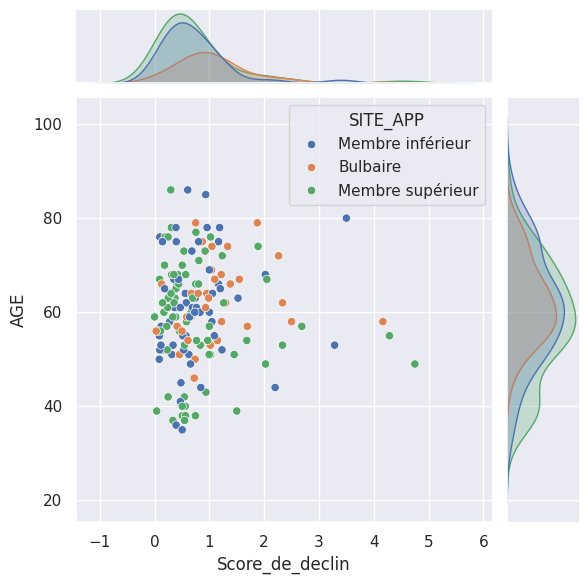

In [519]:
sns.jointplot(x='Score_de_declin',y='AGE', data=df, color='red',hue="SITE_APP")


 nombre d'attribut avant : (200, 1)
xxxxxxxxxxxxxxxxxx
round 0
 xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
190
 ecart-type des predictions : 0.1492847509672821
Moyenne des MAE : 0.26488098588948883
STD des MAE : 0.0
Coefficient de détermination R² : -0.45182014496882617
Coefficient de corrélation de Pearson : -0.040497028424367185
Valeur de p : 0.5691130050358296
xxxxxxxxxxxxxxxxxx
round 1
 xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
190
 ecart-type des predictions : 0.008258859061058652
Moyenne des MAE : 0.25842080748158136
STD des MAE : 0.006460178407907496
Coefficient de détermination R² : -0.0025033213173699664
Coefficient de corrélation de Pearson : -0.012752466898362323
Valeur de p : 0.8577618356345648
xxxxxxxxxxxxxxxxxx
round 2
 xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
190
 ecart-type des predictions : 0.041465006570444204
Moyenne des MAE : 0.25559099900087184
STD des MAE : 0.006621044891076765
Coefficient de détermination R² : -0.11625271936564241
Coefficient de corrélation de Pearson : -0.0436

/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/numpy/core/_methods.py:129: Runt

xxxxxxxxxxxxxxxxxx
round 4
 xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
190
 ecart-type des predictions : 17299996386118.795
Moyenne des MAE : 0.27887169689130387
STD des MAE : 0.029056329435053867
Coefficient de détermination R² : -3.689472523850594e+27
Coefficient de corrélation de Pearson : -0.05417515508669928
Valeur de p : 0.44611380677714735
xxxxxxxxxxxxxxxxxx
round 5
 xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
190
 ecart-type des predictions : 86762841662617.31
Moyenne des MAE : 0.2899531844477998
STD des MAE : 0.036298145946992766
Coefficient de détermination R² : -9.20331624787956e+28
Coefficient de corrélation de Pearson : 0.05133227678353975
Valeur de p : 0.4703720495111836
xxxxxxxxxxxxxxxxxx
round 6
 xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
190
 ecart-type des predictions : 93046367202050.27
Moyenne des MAE : 0.2943976748626616
STD des MAE : 0.03532497939973647
Coefficient de détermination R² : -1.0147728407368018e+29
Coefficient de corrélation de Pearson : -0.11263565318405544
Valeur de p 

/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/numpy/core/_methods.py:129: Runt

xxxxxxxxxxxxxxxxxx
round 8
 xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
190
 ecart-type des predictions : 161706973955613.47
Moyenne des MAE : 0.33452755159319536
STD des MAE : 0.10439883442768172
Coefficient de détermination R² : -3.1514886055031576e+29
Coefficient de corrélation de Pearson : 0.009248482775135696
Valeur de p : 0.8965852108419983
xxxxxxxxxxxxxxxxxx
round 9
 xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
190
 ecart-type des predictions : 82096013354591.42
Moyenne des MAE : 0.3740871068793864
STD des MAE : 0.15457629409726284
Coefficient de détermination R² : -7.995909386052635e+28
Coefficient de corrélation de Pearson : -0.10468013578101602
Valeur de p : 0.1401648667720408
xxxxxxxxxxxxxxxxxx
round 10
 xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
190
 ecart-type des predictions : 170746834179821.88
Moyenne des MAE : 0.43802697656588896
STD des MAE : 0.25020937957064476
Coefficient de détermination R² : -3.3390946680096765e+29
Coefficient de corrélation de Pearson : -0.15967611150937946
Valeur de

/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/numpy/core/_methods.py:129: Runt

xxxxxxxxxxxxxxxxxx
round 13
 xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
190
 ecart-type des predictions : 844088693671435.9
Moyenne des MAE : 2.6052483916996674
STD des MAE : 5.0189533774316635
Coefficient de détermination R² : -8.142342230979335e+30
Coefficient de corrélation de Pearson : -0.16027185045094033
Valeur de p : 0.02338690155308966
xxxxxxxxxxxxxxxxxx
round 14
 xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
190
 ecart-type des predictions : 949460367261328.5
Moyenne des MAE : 2.8673266282790753
STD des MAE : 4.9469340842334395
Coefficient de détermination R² : -1.0870061331741239e+31
Coefficient de corrélation de Pearson : 0.04476213113236441
Valeur de p : 0.5291004221437884
xxxxxxxxxxxxxxxxxx
round 15
 xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
190
 ecart-type des predictions : 253678852187938.7
Moyenne des MAE : 3.2077844631411376
STD des MAE : 4.968029799772297
Coefficient de détermination R² : -7.52626837793272e+29
Coefficient de corrélation de Pearson : -0.1388339611177253
Valeur de p : 0.04

/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/numpy/core/_methods.py:129: Runt

 ecart-type des predictions : 279032178561864.6
Moyenne des MAE : 3.2093762105345274
STD des MAE : 4.715429222119219
Coefficient de détermination R² : -9.24993332974628e+29
Coefficient de corrélation de Pearson : 0.08361489481554421
Valeur de p : 0.2391381120343444
xxxxxxxxxxxxxxxxxx
round 18
 xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
190
 ecart-type des predictions : 176084321099371.34
Moyenne des MAE : 3.1044814127714147
STD des MAE : 4.611187240882771
Coefficient de détermination R² : -3.564450445069146e+29
Coefficient de corrélation de Pearson : -0.15445964389901432
Valeur de p : 0.028975480114041323
xxxxxxxxxxxxxxxxxx
round 19
 xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
190
 ecart-type des predictions : 305200479480307.06
Moyenne des MAE : 3.116407908301238
STD des MAE : 4.4947300215444415
Coefficient de détermination R² : -1.1124143309428563e+30
Coefficient de corrélation de Pearson : -0.09947564847329378
Valeur de p : 0.1610769372944366


/tmp/ipykernel_2179880/665080546.py:80: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


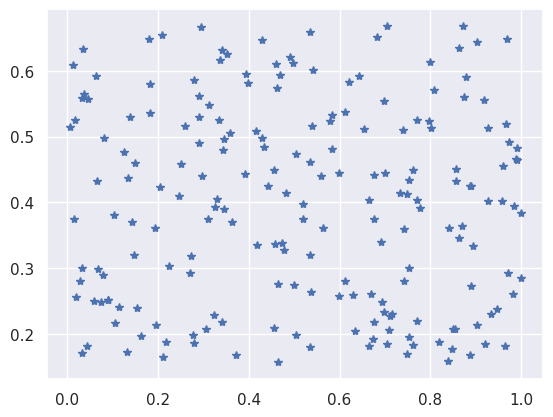

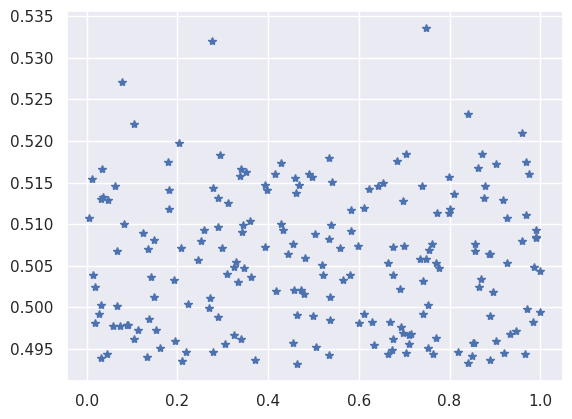

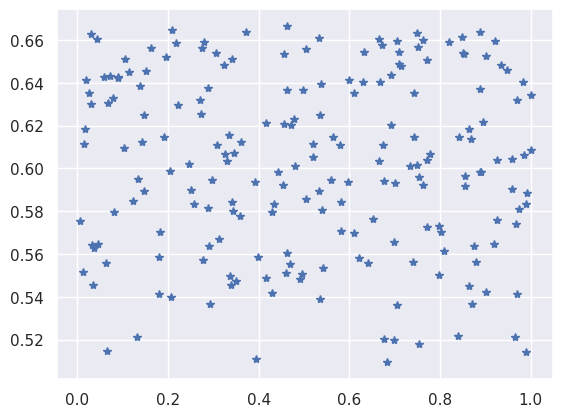

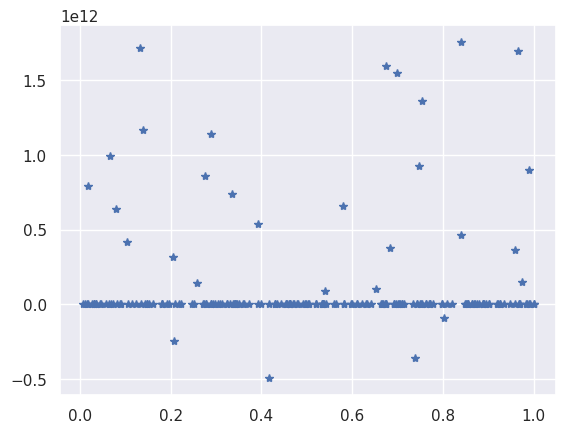

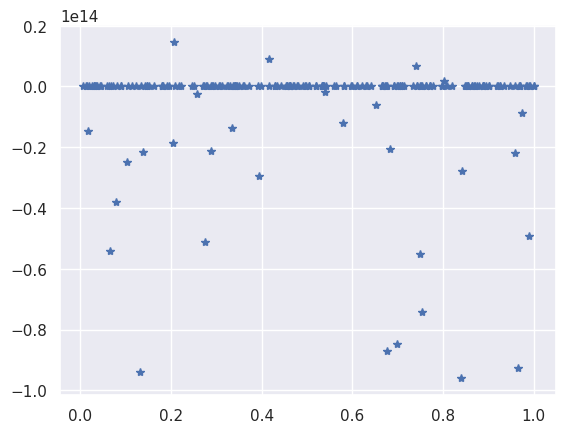

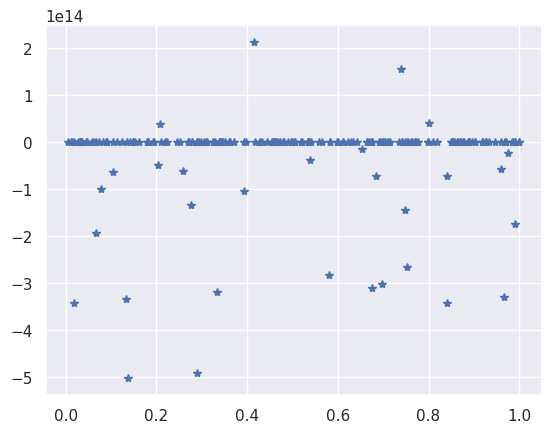

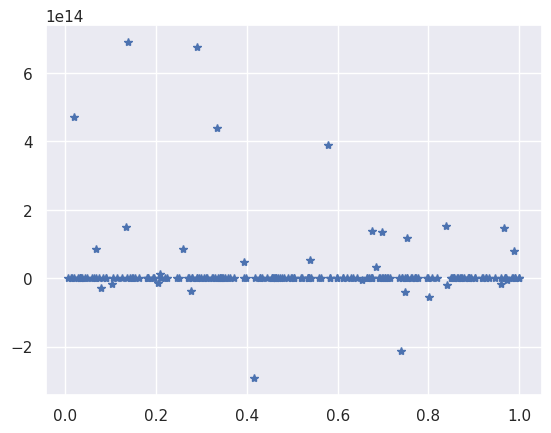

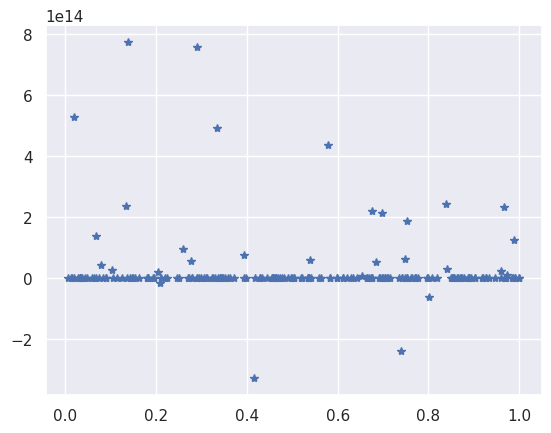

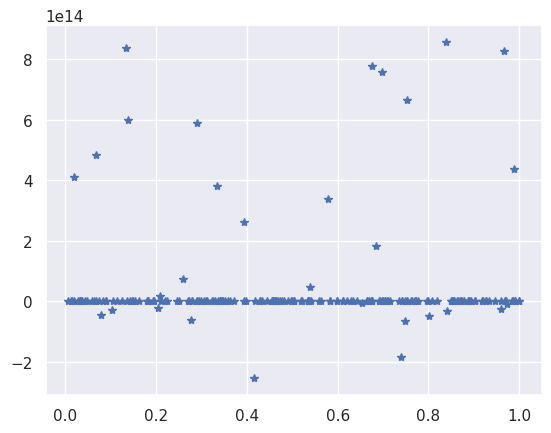

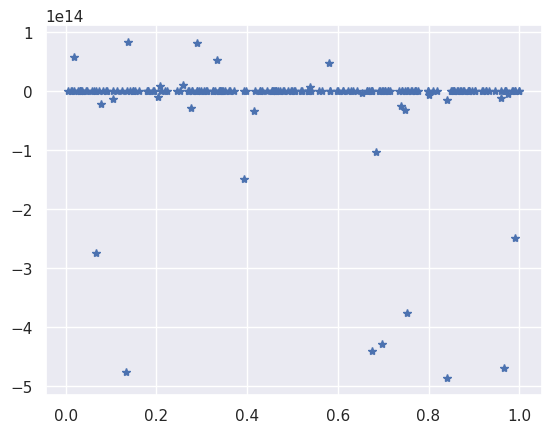

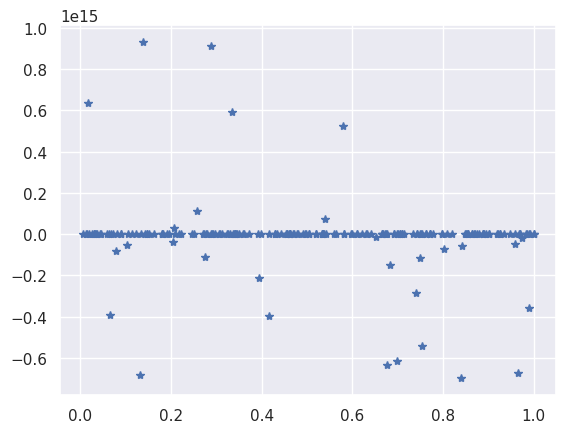

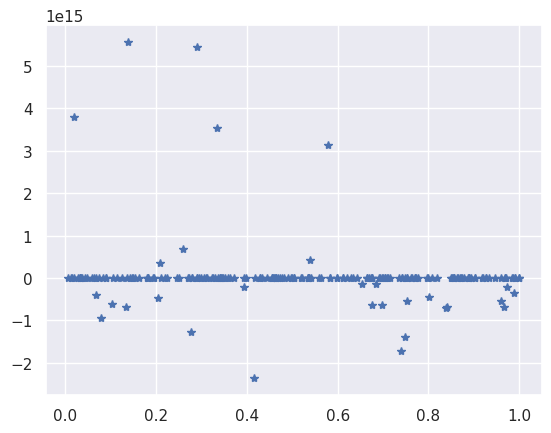

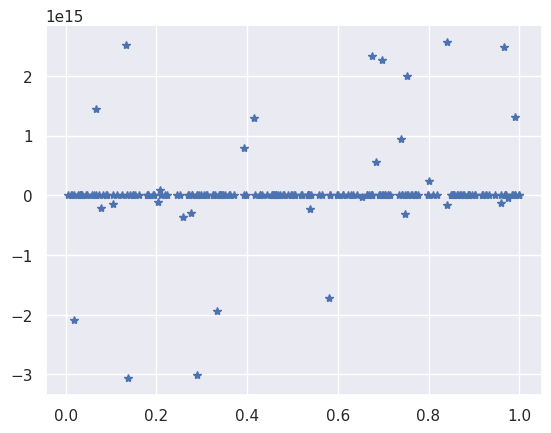

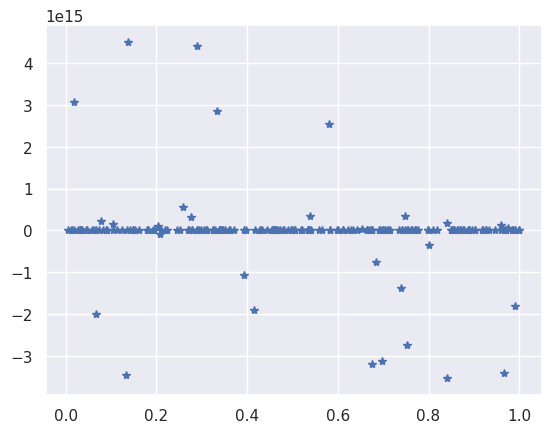

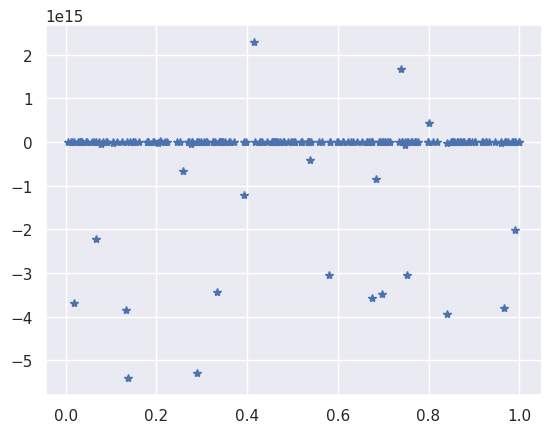

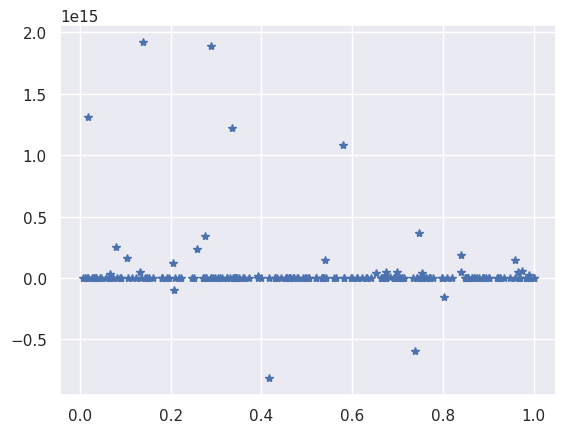

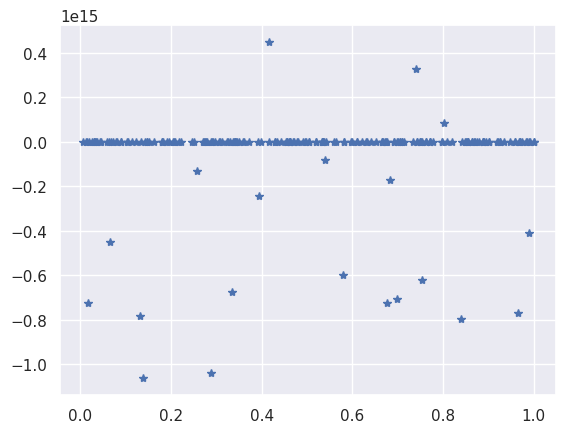

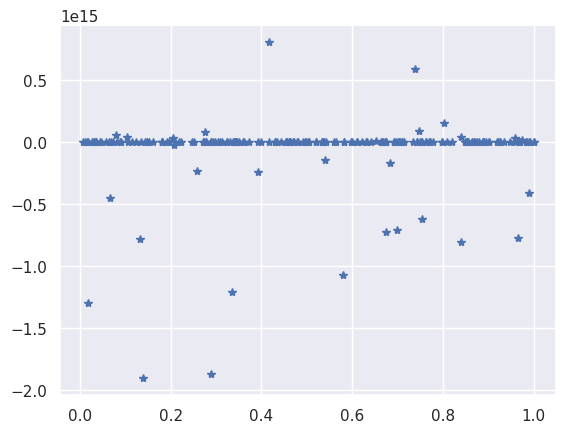

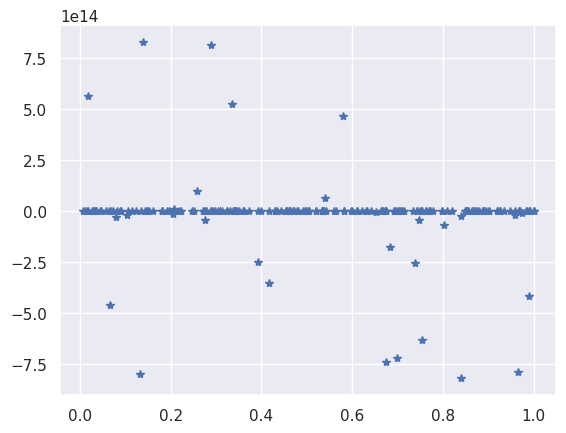

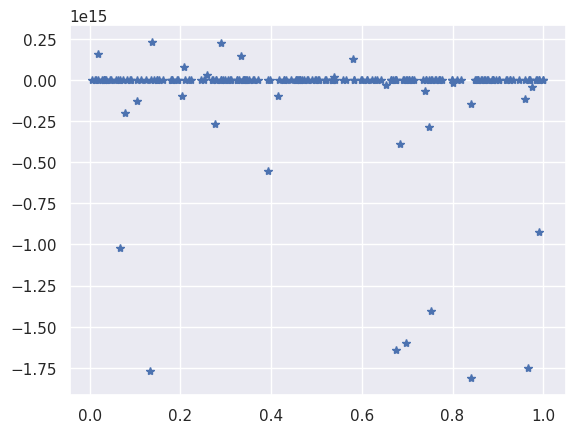

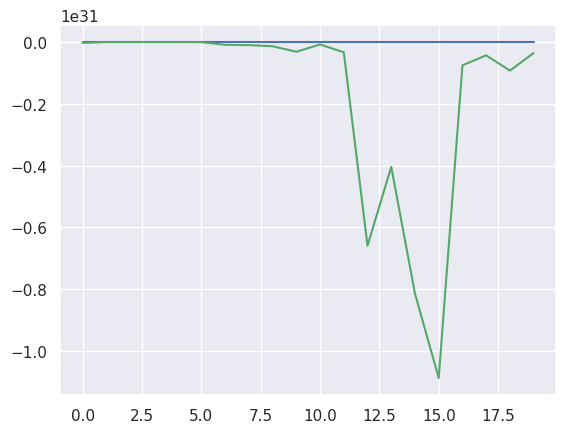

In [599]:
colonne1 = np.random.rand(200)
colonne2 = np.random.rand(200)
from sklearn.model_selection import KFold

# Créer un DataFrame avec les deux colonnes
df = pd.DataFrame({"Score_de_declin": colonne1, "rand": colonne2})

FULL_R2=[]
FULL_score=[]
FULL_score_ent=[]
#for cpt in np.arange(30):
X = df.drop(columns=['Score_de_declin'])
y = df['Score_de_declin']
print(f" nombre d'attribut avant : {X.shape}")

# Exécuter l'évaluation en Leave One Out en utilisant l'objet LeaveOneOut sur le pipeline de traitement des données et les données d'entrée et de sortie
scores=[]
scores_ent=[]
y_true=[]
y_pred=[]


# Définir le nombre de plis pour la cross-validation
n_folds = 20

# Définir la stratégie de cross-validation
kf = KFold(n_splits=n_folds, shuffle=True)

# Effectuer la cross-validation et la sélection de variables
for cpt,split in enumerate(kf.split(X)):
    train_index=split[0]
    test_index=split[1]
    print(f"xxxxxxxxxxxxxxxxxx\nround {cpt}\n xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")

    X = df.drop(columns=['Score_de_declin'])
    y = df['Score_de_declin']

    print(len(train_index))
    y_pred=np.random.rand(200)
    ridge1 = LinearRegression()
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y[train_index], y[test_index]
    ridge1.fit(X_train, y_train)
    #print(ridge1.coef_,ridge1.intercept_)
    y_pred[test_index]=ridge1.predict(X_test)
    
    ridge1 = LinearRegression()
    ridge1.fit(X_test, y_test)
    #print(ridge1.coef_,ridge1.intercept_)
    y_pred[train_index]=ridge1.predict(X_train)

    score = median_absolute_error(y,y_pred)
    scores.append(score)

    df[f"Score_de_declin_predit_{cpt}"]=np.array(y_pred)[:]
    
    print(f" ecart-type des predictions : {np.std(y_pred)}")
    FULL_R2.append(r2)
    FULL_score.append(np.mean(scores))
    FULL_score_ent.append(np.mean(scores_ent))
    r2 = r2_score(y, y_pred)

    print('Moyenne des MAE :', np.mean(scores))
    print('STD des MAE :', np.std(scores))
    r2 = r2_score(y, y_pred)
    print('Coefficient de détermination R² :', r2)
    r, p = scipy.stats.pearsonr(y, y_pred)
    print("Coefficient de corrélation de Pearson :", r)
    print("Valeur de p :", p)

    plt.figure()
    plt.plot(y, y_pred,"*")
    
plt.figure()
plt.plot(FULL_score)
plt.plot(FULL_score_ent)
plt.plot(FULL_R2)

 nombre d'attribut avant : (173, 1)
 nombre d'attribut après : (173, 7)
 ecart-type des predictions : 0.0898761217536651
 nombre d'attribut avant : (173, 2)
 nombre d'attribut après : (173, 14)
 ecart-type des predictions : 0.6843246838833614
 nombre d'attribut avant : (173, 3)
 nombre d'attribut après : (173, 21)
 ecart-type des predictions : 0.7910219227722568
0.8227403667999624
-0.006298769506500962
 nombre d'attribut avant : (173, 4)
 nombre d'attribut après : (173, 28)
 ecart-type des predictions : 0.821450005856122
-0.032985218421827556
-0.04052700274175561
 nombre d'attribut avant : (173, 5)
 nombre d'attribut après : (173, 35)
 ecart-type des predictions : 0.8537506756991536
0.05077286633088496
0.005962431220188719
 nombre d'attribut avant : (173, 6)
 nombre d'attribut après : (173, 42)
 ecart-type des predictions : 0.8412611953104749
-0.08138186962863558
-0.006902691715207215
Moyenne des MAE : 0.18871104910634426
STD des MAE : 0.37206267624552525
Moyenne des MAE ent : 0.096991

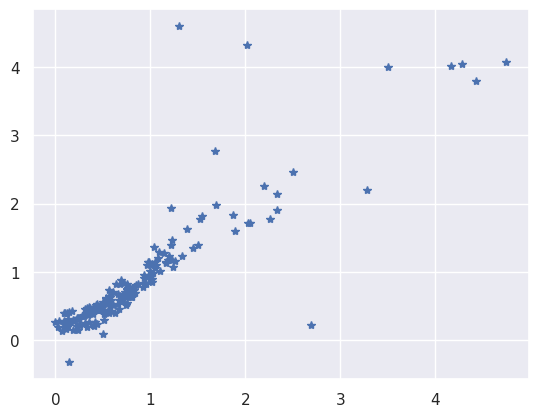

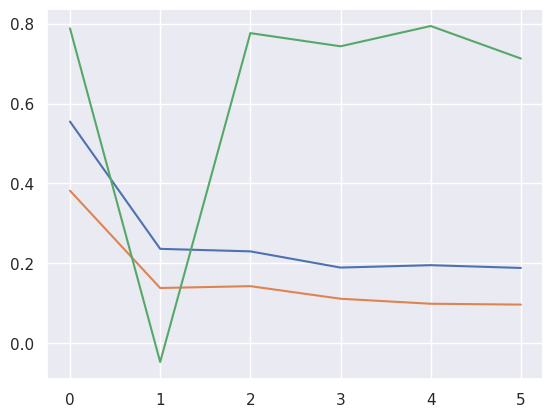

In [548]:
from sklearn import linear_model
import scipy.stats
#'RILU','V0','SEXE','AGE','SITE_APP'
#df=df_part[['Declin','Score_de_declin','SITE_APP']].dropna().join(data.iloc[:,25:])
df=df_part[['Declin','Score_de_declin']].dropna().join(data.iloc[:,26:])
df=df.dropna()
#df['Site_declin'] = df.apply(combine_gp, axis=1)
df = df.rename(columns=lambda x: x.replace("Mediane ", ""))

FULL_R2=[]
FULL_score=[]
FULL_score_ent=[]
for cpt in np.arange(30):
    #X = df.drop(columns=['Declin','Score_de_declin','Site_declin'])
    X = df.drop(columns=['Declin','Score_de_declin'])
    y = df['Score_de_declin']
    print(f" nombre d'attribut avant : {X.shape}")

    # Encoder les variables catégorielles en utilisant OneHotEncoder
    encoder = OneHotEncoder(handle_unknown='ignore')
    X_encoded = encoder.fit_transform(X.select_dtypes(include=['object', 'category']))
    
    TMP_X=X.select_dtypes(include=np.number)

    # générez des valeurs aléatoires entre 0 et 1 pour ces colonnes
    #cols_to_replace = TMP_X.columns[1:]
    #new_vals = np.random.rand(TMP_X.shape[0], len(cols_to_replace))
    # remplacez les valeurs dans le DataFrame
    #TMP_X[cols_to_replace] = new_vals
    
    #TMP=np.clip(TMP_X,np.quantile(TMP_X,0),np.quantile(TMP_X,0.99))
    # Créer un objet MinMaxScaler()
    scaler = MinMaxScaler()
    # Mettre à l'échelle chaque colonne du tableau entre 0 et 1
    X_scaled = scaler.fit_transform(TMP_X)

    # Rescaler les variables quantitatives en utilisant SplineTransformer
    transformer = SplineTransformer(degree=3)
    X_rescaled = transformer.fit_transform(TMP_X)

    # Concaténer les variables encodées et les variables rescalées en un seul DataFrame
    X = np.concatenate((X_encoded.toarray(),X_rescaled),axis=1)
    print(f" nombre d'attribut après : {X.shape}")
    loo = LeaveOneOut()

    # Exécuter l'évaluation en Leave One Out en utilisant l'objet LeaveOneOut sur le pipeline de traitement des données et les données d'entrée et de sortie
    scores=[]
    scores_ent=[]
    y_true=[]
    y_pred=[]
    for train_index, test_index in loo.split(X):
        ridge1 = Ridge(alpha=0.1)
        #ridge1 = linear_model.LinearRegression()
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        ridge1.fit(X_train, y_train)
        score_ent = median_absolute_error(y_train, ridge1.predict(X_train))
        score = median_absolute_error(y_test, ridge1.predict(X_test))
        y_true.append(y_test.values[0])
        y_pred.append(ridge1.predict(X_test)[0])
        scores.append(score)
        scores_ent.append(score_ent)
    print(f" ecart-type des predictions : {np.std(y_pred)}")
    FULL_R2.append(r2)
    FULL_score.append(np.mean(scores))
    FULL_score_ent.append(np.mean(scores_ent))
    r2 = r2_score(y_true, y_pred)

    if len(FULL_R2)>2 :
        print((FULL_R2[-1]-FULL_R2[-2]))
        print((FULL_score[-1]-FULL_score[-2]))
        #AJOUT des res precendent
        if (((FULL_R2[-1]-FULL_R2[-2]) < 0.01) and ((FULL_score[-1]-FULL_score[-2]) > -0.01)) :
            break

    df[f"Score_de_declin_predit_{cpt}"]=np.array(y_pred)[:] #np.random.uniform(np.min(y),np.max(y),173)
    
plt.figure()
plt.plot(y_true, y_pred,"*")
print('Moyenne des MAE :', np.mean(scores))
print('STD des MAE :', np.std(scores))
print('Moyenne des MAE ent :', np.mean(scores_ent))
print('STD des MAE ent :', np.std(scores_ent))
r2 = r2_score(y_true, y_pred)
print('Coefficient de détermination R² :', r2)
r, p = scipy.stats.pearsonr(y_true, y_pred)
print("Coefficient de corrélation de Pearson :", r)
print("Valeur de p :", p)

plt.figure()
plt.plot(FULL_score)
plt.plot(FULL_score_ent)
plt.plot(FULL_R2)

In [531]:
df = df.rename(columns={"Score_de_declin_predit_5": "Score_de_declin_predit"})
df['Site_declin_Pred'] = df.apply(combine_gp4Pred, axis=1)

# Convertir les listes de labels en listes d'entiers
label_dict = {'Membre inférieur_Slow': 0, 'Membre inférieur_Fast': 1, 'Bulbaire_Slow': 2,'Bulbaire_Fast': 3,'Membre supérieur_Slow': 4,'Membre supérieur_Fast': 5,}
y_true_int = [label_dict[label] for label in df['Site_declin']]
y_pred_int = [label_dict[label] for label in df['Site_declin_Pred']]

# Créer la matrice de confusion
conf_mat = confusion_matrix(y_true_int, y_pred_int, labels=[0,1,2,3,4,5])
print(conf_mat)

[[29  1  0  0  0  0]
 [ 5 25  0  0  0  0]
 [ 0  0  4  3  0  0]
 [ 0  0  8 24  0  0]
 [ 0  0  0  0 37  5]
 [ 0  0  0  0  1 31]]


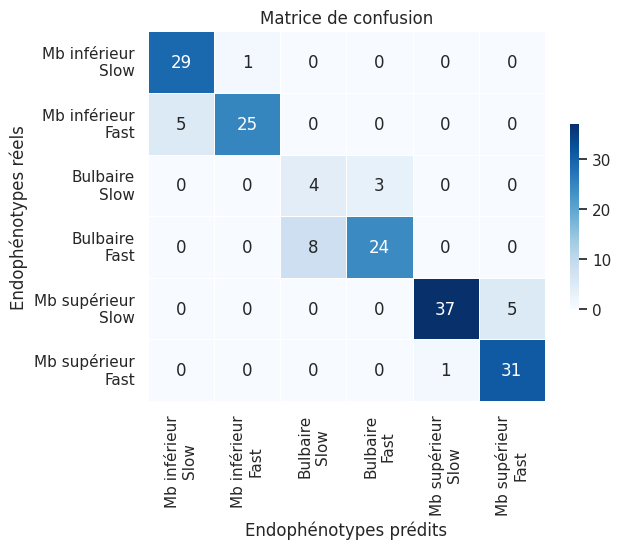

In [532]:
labels=['Mb inférieur\nSlow', 'Mb inférieur\nFast', 'Bulbaire\nSlow','Bulbaire\nFast','Mb supérieur\nSlow','Mb supérieur\nFast']

plt.figure()

# Créer un heatmap à partir de la matrice de confusion
sns.heatmap(conf_mat, annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels,cbar_kws={'shrink': 0.5},linewidths=0.5)
#sns.heatmap(confusion_matrix, annot=True, fmt='d', xticklabels=col_labels, yticklabels=row_labels,annot_kws={'size': 20},cbar_kws={'shrink': 0.5},linewidths=0.5)

# Ajouter un titre et des étiquettes aux axes
plt.title('Matrice de confusion')
plt.xlabel('Endophénotypes prédits')
plt.ylabel('Endophénotypes réels')

# Afficher le heatmap
plt.savefig(os.path.join(DIR,"screenshots","ConfusionMatrix.png"), bbox_inches='tight', pad_inches=0.1)
plt.show()


In [533]:
VP=np.sum((df["Score_de_declin_predit"].values >0.6) & (df["Score_de_declin"].values >0.6))
VN=np.sum((df["Score_de_declin_predit"].values <0.6) & (df["Score_de_declin"].values <0.6))
print(f"VP : {VP}")
print(f"VN : {VN}")
FP=np.sum((df["Score_de_declin_predit"].values >0.6) & (df["Score_de_declin"].values <0.6))
FN=np.sum((df["Score_de_declin_predit"].values <0.6) & (df["Score_de_declin"].values >0.6))
print(f"FP : {FP}")
print(f"FN : {FN}")

# Calculer la sensibilité et la spécificité
sensibilite = VP / (VP + FN)
specificite = VN / (VN + FP)

# Afficher les résultats
print('Sensibilité :', sensibilite)
print('Spécificité :', specificite)


VP : 80
VN : 70
FP : 9
FN : 14
Sensibilité : 0.851063829787234
Spécificité : 0.8860759493670886


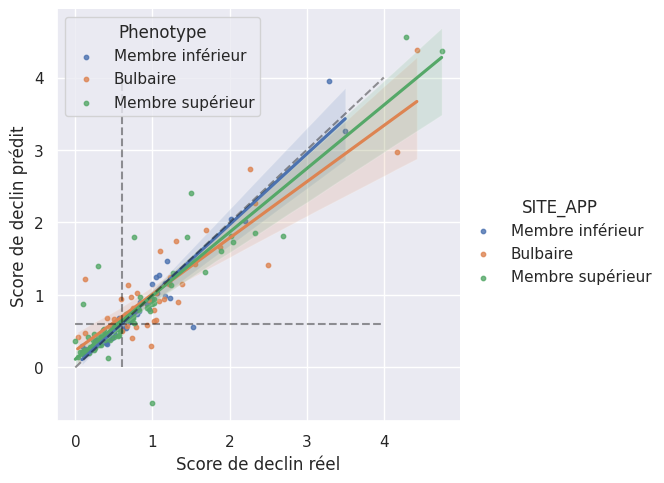

In [534]:
#df=df.drop(columns='Score_de_declin_predit')
df['Score_de_declin_predit']=np.array(y_pred)[:]

g = sns.lmplot(
    data=df,
    x="Score_de_declin", y="Score_de_declin_predit", hue="SITE_APP",
    height=5,
    scatter_kws={"s": 10}
)

# ajoutez la ligne y=x en pointillé
plt.plot([0, 4], [0, 4], linestyle='--', color='black',alpha=0.4)

# ajoutez la ligne y=0.6 en pointillé
plt.plot([0, 4], [0.6, 0.6], linestyle='--', color='black',alpha=0.4)

# ajoutez la ligne x=0.6 en pointillé
plt.plot([0.6, 0.6], [0, 4], linestyle='--', color='black',alpha=0.4)

plt.gca().legend(title="Phenotype")

# Use more informative axis labels than are provided by default
g.set_axis_labels("Score de declin réel", "Score de declin prédit")
plt.savefig(os.path.join(DIR,"screenshots","ModeleRecursifRidge.png"))


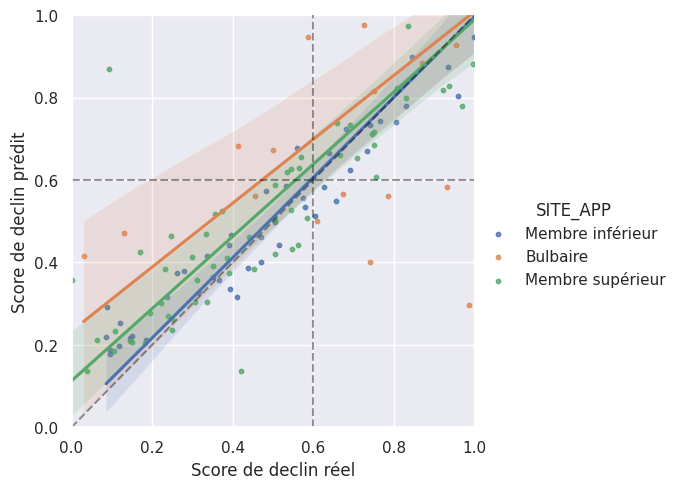

In [535]:
g = sns.lmplot(
    data=df,
    x="Score_de_declin", y="Score_de_declin_predit", hue="SITE_APP",
    height=5,
    scatter_kws={"s": 10}
)

# ajoutez la ligne y=x en pointillé
plt.plot([0, 1], [0, 1], linestyle='--', color='black',alpha=0.4)

# ajoutez la ligne y=0.6 en pointillé
plt.plot([0, 1], [0.6, 0.6], linestyle='--', color='black',alpha=0.4)

# ajoutez la ligne x=0.6 en pointillé
plt.plot([0.6, 0.6], [0, 1], linestyle='--', color='black',alpha=0.4)

# limitez l'axe des x entre 0 et 1
plt.gca().set_xlim(0, 1)

# limitez l'axe des y entre 0 et 1
plt.gca().set_ylim(0, 1)

# Use more informative axis labels than are provided by default
g.set_axis_labels("Score de declin réel", "Score de declin prédit")
plt.savefig(os.path.join(DIR,"screenshots","ModeleRecursifRidgeZoom.png"))

In [536]:
for SITE_APP in df['SITE_APP'].unique():
    print(SITE_APP)
    df_perm=df.loc[df['SITE_APP']==SITE_APP]; 
    VP=np.sum((df_perm["Score_de_declin_predit"].values >0.6) & (df_perm["Score_de_declin"].values >0.6))
    VN=np.sum((df_perm["Score_de_declin_predit"].values <0.6) & (df_perm["Score_de_declin"].values <0.6))
    print(f"VP : {VP}")
    print(f"VN : {VN}")
    FP=np.sum((df_perm["Score_de_declin_predit"].values >0.6) & (df_perm["Score_de_declin"].values <0.6))
    FN=np.sum((df_perm["Score_de_declin_predit"].values <0.6) & (df_perm["Score_de_declin"].values >0.6))
    print(f"FP : {FP}")
    print(f"FN : {FN}")

    # Calculer la sensibilité et la spécificité
    sensibilite = VP / (VP + FN)
    specificite = VN / (VN + FP)

    # Afficher les résultats
    print(f"Sensibilité : {sensibilite:.3f}")
    print(f"Spécificité : {specificite:.3f}")


Membre inférieur
VP : 26
VN : 29
FP : 1
FN : 4
Sensibilité : 0.867
Spécificité : 0.967
Bulbaire
VP : 26
VN : 3
FP : 4
FN : 6
Sensibilité : 0.812
Spécificité : 0.429
Membre supérieur
VP : 31
VN : 36
FP : 6
FN : 1
Sensibilité : 0.969
Spécificité : 0.857


### Logistic regression

Modèle de classification du phénotype : <br>
* transformation non-linéaire (spline) des données quantitatives d'entrées  <br>
* Validation croisée pour l'optimisation de l'hyperparamètre C <br>
* Et évaluation du modèle par Leave One Out <br>

In [408]:
# Séparer la colonne à prédire "declin" du DataFrame
X = df.drop(columns=['Declin','Score_de_declin','Site_declin'])
y = df['Site_declin']

# Encoder les variables catégorielles en utilisant OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore')
X_encoded = encoder.fit_transform(X.select_dtypes(include=['object', 'category']))

# Rescaler les variables quantitatives en utilisant SplineTransformer
transformer = SplineTransformer(degree=3)
X_rescaled = transformer.fit_transform(X.select_dtypes(include=np.number))

# Concaténer les variables encodées et les variables rescalées en un seul DataFrame
X = np.concatenate((X_encoded.toarray(),X_rescaled),axis=1)

# 2. Création du pipeline de traitement des données

# Créer un pipeline en utilisant Pipeline de scikit-learn pour combiner les étapes de prétraitement des données et la régression logistique
pipeline = Pipeline([
    ('logistic', LogisticRegression())   
])

# 3. Optimisation de l'hyperparamètre C en utilisant une validation croisée

# Créer un objet GridSearchCV de scikit-learn pour effectuer une recherche de grille sur l'hyperparamètre C en utilisant une validation croisée
grid_search = GridSearchCV(pipeline, param_grid={'logistic__C': [0.1, 1, 10, 100]}, cv=5, scoring='f1_macro')

# Exécuter la recherche de grille en utilisant l'objet GridSearchCV sur le pipeline de traitement des données et les données d'entrée et de sortie
grid_search.fit(X, y)

# Afficher la meilleure valeur de l'hyperparamètre C
print('Meilleure valeur de l\'hyperparamètre C :', grid_search.best_params_['logistic__C'])

# 4. Évaluation du modèle en Leave One Out

# Créer un objet LeaveOneOut de scikit-learn pour effectuer une évaluation en Leave One Out
loo = LeaveOneOut()

# Exécuter l'évaluation en Leave One Out en utilisant l'objet LeaveOneOut sur le pipeline de traitement des données et les données d'entrée et de sortie
scores = []
y_true_list=list()
y_pred_list=list()
for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    score = f1_score(y_test, y_pred, average='macro')
    y_true_list.append(y_test[0])
    y_pred_list.append(y_pred[0])
    scores.append(score)

# Afficher la moyenne et l'écart-type des scores
print('Moyenne des scores :', np.mean(scores))
print('Écart-type des scores :', np.std(scores))

/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

Meilleure valeur de l'hyperparamètre C : 10


/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

Moyenne des scores : 0.7052023121387283
Écart-type des scores : 0.45595176399803516


/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

In [411]:
from sklearn.metrics import confusion_matrix

# Convertir les listes de labels en listes d'entiers
label_dict = {'Membre inférieur_Slow': 0, 'Membre inférieur_Fast': 1, 'Bulbaire_Slow': 2,'Bulbaire_Fast': 3,'Membre supérieur_Slow': 4,'Membre supérieur_Fast': 5,}
y_true_int = [label_dict[label] for label in y_true_list]
y_pred_int = [label_dict[label] for label in y_pred_list]

# Créer la matrice de confusion
conf_mat = confusion_matrix(y_true_int, y_pred_int, labels=[0,1,2,3,4,5])
print(conf_mat)

[[19 11  0  0  0  0]
 [13 17  0  0  0  0]
 [ 0  0  0  7  0  0]
 [ 0  0  1 31  0  0]
 [ 0  0  0  0 37  5]
 [ 0  0  0  0 14 18]]


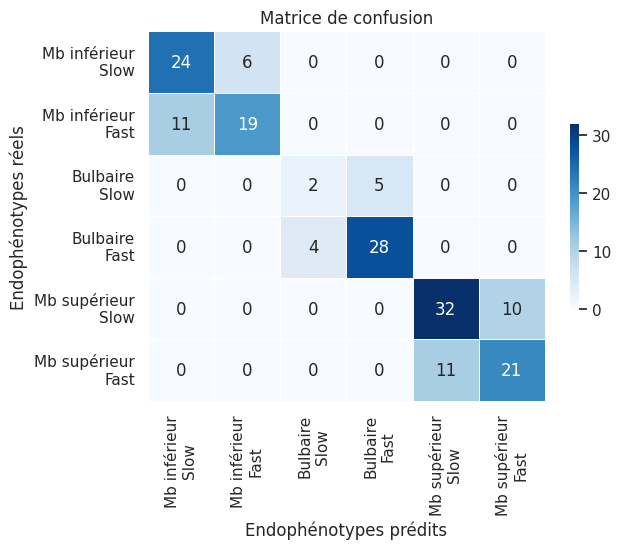

<Figure size 640x480 with 0 Axes>

In [448]:
import seaborn as sns
import matplotlib.pyplot as plt

labels=['Mb inférieur\nSlow', 'Mb inférieur\nFast', 'Bulbaire\nSlow','Bulbaire\nFast','Mb supérieur\nSlow','Mb supérieur\nFast']

# Créer un heatmap à partir de la matrice de confusion
sns.heatmap(conf_mat, annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels,cbar_kws={'shrink': 0.5},linewidths=0.5)
#sns.heatmap(confusion_matrix, annot=True, fmt='d', xticklabels=col_labels, yticklabels=row_labels,annot_kws={'size': 20},cbar_kws={'shrink': 0.5},linewidths=0.5)

# Ajouter un titre et des étiquettes aux axes
plt.title('Matrice de confusion')
plt.xlabel('Endophénotypes prédits')
plt.ylabel('Endophénotypes réels')

# Afficher le heatmap
plt.show()
plt.savefig(os.path.join(DIR,"screenshots","ConfusionMatrix.png"))

In [414]:
VP=np.trace(conf_mat)
FP=np.sum(conf_mat)-np.trace(conf_mat)
print(f"nombre de bien classés : {VP} , {FP} mal classé, c'est à dire {VP*100/np.sum(conf_mat):.2f} %")

nombre de bien classés : 122 , 51 mal classé, c'est à dire 70.52 %


In [89]:
from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(
    df.drop(['Declin','Score_de_declinaison'],axis=1),df['Declin'].values, test_size=0.1, random_state=42
)

In [20]:
from scipy.stats import loguniform
class loguniform_int:
    """Integer valued version of the log-uniform distribution"""

    def __init__(self, a, b):
        self._distribution = loguniform(a, b)

    def rvs(self, *args, **kwargs):
        """Random variable sample"""
        return self._distribution.rvs(*args, **kwargs).astype(int)

In [92]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_selector as selector

categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(df.drop(['Score_de_declinaison','Declin'],axis=1))
categorical_preprocessor = OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=-1
)
preprocessor = ColumnTransformer(
    [("cat_preprocessor", categorical_preprocessor, categorical_columns)],
    remainder="passthrough",
)

In [93]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_validate

model = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("classifier",HistGradientBoostingClassifier(random_state=42, max_leaf_nodes=2)),
    ]
)
            #DecisionTreeClassifier(max_depth=2)
            #DecisionTreeRegressor(max_depth=2)
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_preprocessor',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['SEXE', 'SITE_APP'])])),
                ('classifier',
                 HistGradientBoostingClassifier(max_leaf_nodes=2,
                                                random_state=42))])

In [94]:
%%time
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    ""
    "classifier__l2_regularization": loguniform(1e-6, 1e3),
    "classifier__learning_rate": loguniform(0.001, 10),
    "classifier__max_leaf_nodes": loguniform_int(2, 256),
    "classifier__min_samples_leaf": loguniform_int(1, 100),
    "classifier__max_bins": loguniform_int(2, 255),
}

model_random_search = RandomizedSearchCV(
    model,
    param_distributions=param_distributions,
    n_iter=50,
    cv=5,
    verbose=1,
)
model_random_search.fit(data_train, target_train)
# Afficher les meilleurs hyperparamètres et la performance du modèle
print("Meilleurs hyperparamètres :")
print(model_random_search.best_params_)

print("Performance du modèle :")
print(model_random_search.best_score_)
from pprint import pprint

print("The best parameters are:")
pprint(model_random_search.best_params_)
accuracy = model_random_search.score(data_test, target_test)
print(f"The test accuracy score of the best model is {accuracy:.2f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Meilleurs hyperparamètres :
{'classifier__l2_regularization': 1.3544933257740768, 'classifier__learning_rate': 1.1074360284409086, 'classifier__max_bins': 5, 'classifier__max_leaf_nodes': 80, 'classifier__min_samples_leaf': 1}
Performance du modèle :
0.6583333333333333
The best parameters are:
{'classifier__l2_regularization': 1.3544933257740768,
 'classifier__learning_rate': 1.1074360284409086,
 'classifier__max_bins': 5,
 'classifier__max_leaf_nodes': 80,
 'classifier__min_samples_leaf': 1}
The test accuracy score of the best model is 0.33
CPU times: user 2min 59s, sys: 4.77 s, total: 3min 4s
Wall time: 47 s


In [95]:
# get the parameter names
column_results = [f"param_{name}" for name in param_distributions.keys()]
column_results += ["mean_test_score", "std_test_score", "rank_test_score"]

cv_results = pd.DataFrame(model_random_search.cv_results_)
cv_results = cv_results[column_results].sort_values(
    "mean_test_score", ascending=False
)

def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name


cv_results = cv_results.rename(shorten_param, axis=1)
cv_results

,l2_regularization,learning_rate,max_leaf_nodes,min_samples_leaf,max_bins,mean_test_score,std_test_score,rank_test_score
34,1.354493,1.107436,80,1,5,0.658333,0.034485,1
7,0.000002,0.024183,2,1,3,0.621402,0.058324,2
28,0.000182,0.030467,212,6,5,0.596402,0.025370,3
4,308.895247,4.097569,9,22,25,0.584091,0.039307,4
0,0.000002,0.47347,54,17,9,0.578409,0.079841,5
21,0.001547,0.004687,2,2,3,0.578220,0.052122,6
32,0.001727,0.001892,122,3,9,0.578030,0.042068,7
26,0.000359,0.003462,4,24,6,0.571970,0.055402,8
39,0.000063,0.066475,209,2,5,0.571212,0.083332,9
47,4.245257,1.664193,5,18,7,0.553220,0.063636,10


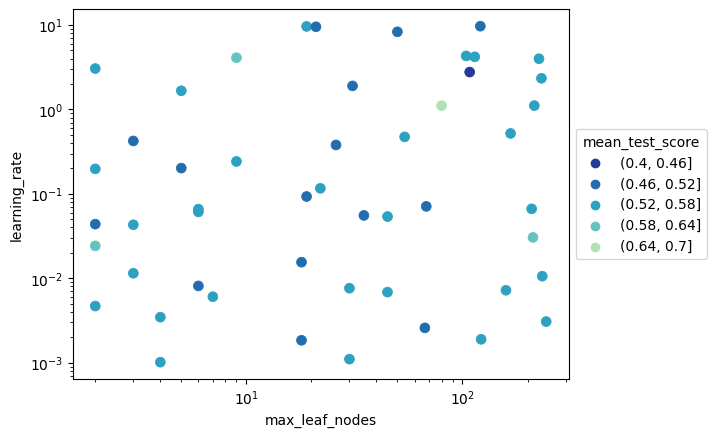

In [97]:

df = pd.DataFrame(
    {
        "max_leaf_nodes": cv_results["max_leaf_nodes"],
        "learning_rate": cv_results["learning_rate"],
        "score_bin": pd.cut(
            cv_results["mean_test_score"], bins=np.linspace(0.4,0.7, 6)
        ),
    }
)
sns.set_palette("YlGnBu_r")
ax = sns.scatterplot(
    data=df,
    x="max_leaf_nodes",
    y="learning_rate",
    hue="score_bin",
    s=50,
    color="k",
    edgecolor=None,
)
ax.set_xscale("log")
ax.set_yscale("log")

_ = ax.legend(
    title="mean_test_score", loc="center left", bbox_to_anchor=(1, 0.5)
)

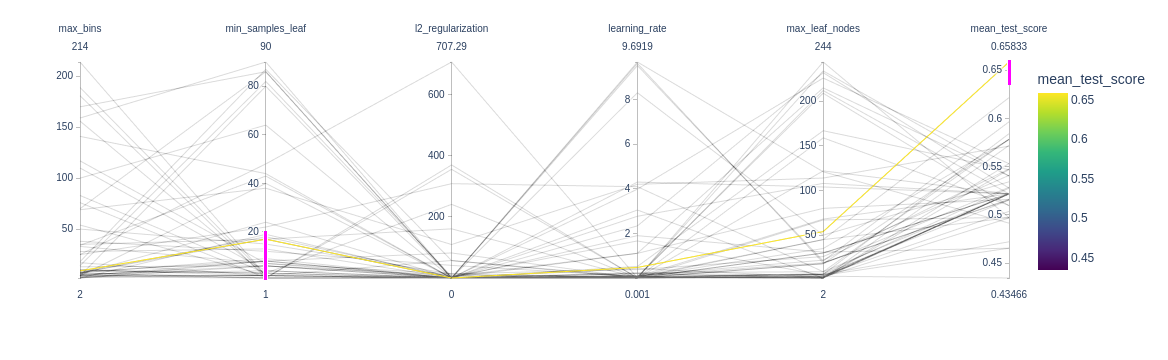

In [112]:
import numpy as np
import plotly.express as px

pd.DataFrame.iteritems = pd.DataFrame.items

fig = px.parallel_coordinates(
    cv_results.rename(shorten_param, axis=1).apply(
        {
            "max_bins": lambda x: x,
            "min_samples_leaf": lambda x: x,
            "l2_regularization": lambda x: x,
            "learning_rate": lambda x: x,
            "max_leaf_nodes": lambda x: x,
            "mean_test_score": lambda x: x
        }
    ),
    color="mean_test_score",
    color_continuous_scale=px.colors.sequential.Viridis,
)
fig.show()

In [ ]:
linear_regression = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False), LinearRegression()
).set_output(transform="pandas")

cv_results = cross_validate(
    linear_regression,
    data,
    target,
    cv=10,
    scoring="neg_mean_squared_error",
    return_train_score=True,
    return_estimator=True,
)

In [ ]:
%%time
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {

}

model_random_search = RandomizedSearchCV(
    model,
    param_distributions=param_distributions,
    n_iter=10,
    cv=5,
    verbose=1,
)
model_random_search.fit(data_train, target_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
CPU times: user 248 ms, sys: 865 µs, total: 249 ms
Wall time: 249 ms


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('cat_preprocessor',
                                                                               OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                              unknown_value=-1),
                                                                               ['SEXE'])])),
                                             ('classifier',
                                              DecisionTreeRegressor(max_depth=2))]),
                   param_distributions={}, verbose=1)

The test accuracy score of the best model is 0.47


In [ ]:
target_test

array([0.69211196, 0.54372624, 0.92307692, 0.3       , 0.67257039,
       1.38181818, 1.02173913, 0.45454545, 0.8313253 , 0.56908777,
       0.74959872, 1.        , 0.08607367, 0.15092025, 0.05128205,
       0.10440395, 0.76548673, 0.03017271, 1.16666667, 0.60526316,
       0.93171426, 4.28571429, 1.0798391 , 1.01937984, 0.35138004,
       0.62660256, 0.10797764, 0.3111546 , 0.26159486, 0.2230441 ,
       0.24908425, 0.24746964, 0.30677184, 4.75      , 0.56159794,
       0.13020503, 0.50388914, 0.56345635, 1.23076923, 2.2       ,
       3.5       , 0.57364847, 0.23809524, 1.        , 0.38592751])

#Pour demain : ajouter des variables , utiliser le scaler pour des variables catégorielles, changer de modèle ....

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

X = [df['Declin']=="Slow"]
y = df.drop(['SEXE','SITE_APP','Declin','Score_de_declinaison'],axis=1)

# Définir le classifieur KNN
knn = KNeighborsClassifier()

# Définir les paramètres et les distributions de paramètres à utiliser pour la recherche aléatoire
param_distribs = {'n_neighbors': np.arange(1, 21),
                  'weights': ['uniform', 'distance'],
                  'metric': ['euclidean', 'manhattan', 'chebyshev']}

# Créer une instance de RandomizedSearchCV
rscv = RandomizedSearchCV(estimator=knn, param_distributions=param_distribs, n_iter=50, cv=5)

# Effectuer la recherche aléatoire de paramètres
rscv.fit(X, y)

# Afficher les meilleurs paramètres et le meilleur score obtenus
print("Meilleurs paramètres :", rscv.best_params_)
print("Meilleur score :", rscv.best_score_)

ValueError: 
All the 250 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py", line 215, in fit
    return self._fit(X, y)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py", line 454, in _fit
    X, y = self._validate_data(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 584, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 1106, in check_X_y
    X = check_array(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 902, in check_array
    raise ValueError(
ValueError: Expected 2D array, got 1D array instead:
array=[False  True  True  True False False False False  True False False  True
  True False False False  True  True False  True False  True False  True
 False False False False False False False  True False  True  True  True
 False False False  True False False False  True  True  True  True  True
 False  True  True False False  True  True False False  True  True  True
  True False  True False  True  True False False  True  True  True  True
  True  True  True  True False False  True  True False  True False False
 False False False  True  True False False  True False False  True False
  True False False False False False  True False  True False False  True
 False False False  True False False False False  True  True False  True
  True False  True False False False False False  True  True  True False
  True  True  True False  True False False  True  True  True False].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py", line 215, in fit
    return self._fit(X, y)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py", line 454, in _fit
    X, y = self._validate_data(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 584, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 1106, in check_X_y
    X = check_array(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 902, in check_array
    raise ValueError(
ValueError: Expected 2D array, got 1D array instead:
array=[ True  True  True False False  True  True False  True False False False
 False  True  True  True  True False False False  True  True  True False
  True False  True  True False  True False  True  True False False False
 False False False  True False False False  True  True  True  True  True
 False  True  True False False  True  True False False  True  True  True
  True False  True False  True  True False False  True  True  True  True
  True  True  True  True False False  True  True False  True False False
 False False False  True  True False False  True False False  True False
  True False False False False False  True False  True False False  True
 False False False  True False False False False  True  True False  True
  True False  True False False False False False  True  True  True False
  True  True  True False  True False False  True  True  True False].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py", line 215, in fit
    return self._fit(X, y)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py", line 454, in _fit
    X, y = self._validate_data(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 584, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 1106, in check_X_y
    X = check_array(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 902, in check_array
    raise ValueError(
ValueError: Expected 2D array, got 1D array instead:
array=[ True  True  True False False  True  True False  True False False False
 False  True  True  True  True False False False  True  True  True False
  True False  True  True False  True False  True  True False False False
 False  True  True  True False False False False  True False False  True
  True False False False  True  True False  True False  True False  True
 False False False False False False False  True False  True  True  True
  True  True  True  True False False  True  True False  True False False
 False False False  True  True False False  True False False  True False
  True False False False False False  True False  True False False  True
 False False False  True False False False False  True  True False  True
  True False  True False False False False False  True  True  True False
  True  True  True False  True False False  True  True  True False].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py", line 215, in fit
    return self._fit(X, y)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py", line 454, in _fit
    X, y = self._validate_data(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 584, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 1106, in check_X_y
    X = check_array(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 902, in check_array
    raise ValueError(
ValueError: Expected 2D array, got 1D array instead:
array=[ True  True  True False False  True  True False  True False False False
 False  True  True  True  True False False False  True  True  True False
  True False  True  True False  True False  True  True False False False
 False  True  True  True False False False False  True False False  True
  True False False False  True  True False  True False  True False  True
 False False False False False False False  True False  True  True  True
 False False False  True False False False  True  True  True  True  True
 False  True  True False False  True  True False False  True  True  True
  True False  True False  True  True False False  True  True  True  True
 False False False  True False False False False  True  True False  True
  True False  True False False False False False  True  True  True False
  True  True  True False  True False False  True  True  True False].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py", line 215, in fit
    return self._fit(X, y)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py", line 454, in _fit
    X, y = self._validate_data(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 584, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 1106, in check_X_y
    X = check_array(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 902, in check_array
    raise ValueError(
ValueError: Expected 2D array, got 1D array instead:
array=[ True  True  True False False  True  True False  True False False False
 False  True  True  True  True False False False  True  True  True False
  True False  True  True False  True False  True  True False False False
 False  True  True  True False False False False  True False False  True
  True False False False  True  True False  True False  True False  True
 False False False False False False False  True False  True  True  True
 False False False  True False False False  True  True  True  True  True
 False  True  True False False  True  True False False  True  True  True
  True False  True False  True  True False False  True  True  True  True
  True  True  True  True False False  True  True False  True False False
 False False False  True  True False False  True False False  True False
  True False False False False False  True False  True False False  True].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
